In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import random
import torchaudio

random.seed(0)
np.random.seed(0)

In [2]:
!nvidia-smi

Tue Aug 15 22:52:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0  On |                  N/A |
| 33%   56C    P3             108W / 350W |    684MiB / 24576MiB |     11%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('/home/vmachado/Documents/c4ai_clip_audio_text/data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
go_emotions = pd.concat([train_text, test_text])

In [5]:
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust          664
fear             705
joy            19002
neutral        14429
sadness         2936
surprise        5062

In [6]:
anger = go_emotions[go_emotions["grouped_label"] == "anger"].sample(5000, replace=False, random_state=0)
disgust = go_emotions[go_emotions["grouped_label"] == "disgust"].sample(4000, replace=True, random_state=0)
fear = go_emotions[go_emotions["grouped_label"] == "fear"].sample(4000, replace=True, random_state=0)
joy = go_emotions[go_emotions["grouped_label"] == "joy"].sample(5000, replace=False, random_state=0)
neutral = go_emotions[go_emotions["grouped_label"] == "neutral"].sample(2000, replace=False, random_state=0)
sadness = go_emotions[go_emotions["grouped_label"] == "sadness"].sample(2000, replace=True, random_state=0)

In [7]:
#go_emotions = go_emotions[go_emotions["grouped_label"] != "anger"]
#go_emotions = go_emotions[go_emotions["grouped_label"] != "joy"]
#go_emotions = go_emotions[go_emotions["grouped_label"] != "neutral"]
go_emotions = pd.concat([go_emotions, disgust, fear, sadness])
go_emotions.groupby("grouped_label").count()

text
grouped_label       
anger           6039
disgust         4664
fear            4705
joy            19002
neutral        14429
sadness         4936
surprise        5062

In [8]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [9]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [10]:
pd.concat([train_audio,test_audio]).groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise   592

In [11]:
audio_datasets = pd.concat([train_audio,test_audio]).reset_index(drop=True)

In [12]:
surprise = audio_datasets[audio_datasets["label"] == "surprise"].sample(2000, replace=True, random_state=0)
audio_datasets = audio_datasets[audio_datasets["label"] != "surprise"]
audio_datasets = pd.concat([audio_datasets, surprise]).reset_index(drop=True)
#audio_datasets

In [13]:
audio_datasets.groupby("label").count()

path
label         
anger     1863
disgust   1863
fear      1863
joy       2055
neutral   1583
sadness   1863
surprise  2000

## Load Meld and IEMOCAP

In [14]:
train_df_erc = pd.read_csv("train_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
train_df_erc["path"] = train_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
train_df_erc

text     label  \
0      The only one I know still love his parents. [B...       joy   
1      The only one I know still love his parents. Ye...   neutral   
2      Oh it's not bad thing it's good thing. You kno...       joy   
3      You know it's nice here, the air is sweet. You...   sadness   
4      You're not sorry you came? Not sorry, no.  I c...   sadness   
...                                                  ...       ...   
13723  That would be no. Come on. It doesn't taste ba...   neutral   
13724  Come on. It doesn't taste bad. Yeah, it's kind...       joy   
13725  Yeah, it's kinda sweet, sorta like, uh... Cant...   neutral   
13726  Cantaloupe juice. Exactly. [BFR] You've tasted...  surprise   
13727  Exactly. You've tasted it? You've tasted it. [...   neutral   

                                                    path  
0      /home/vmachado/Documents/multimodal-datasets/I...  
1      /home/vmachado/Documents/multimodal-datasets/I...  
2      /home/vmachado/Documents/multimodal-datasets/I...  
3      /home/vmachado/Documents/multimodal-datasets/I...  
4      /home/vmachado/Documents/multimodal-datasets/I...  
...                                                  ...  
13723  /home/vmachado/Documents/multimodal-datasets/M...  
13724  /home/vmachado/Documents/multimodal-datasets/M...  
13725  /home/vmachado/Documents/multimodal-datasets/M...  
13726  /home/vmachado/Documents/multimodal-datasets/M...  
13727  /home/vmachado/Documents/multimodal-datasets/M...  

[13728 rows x 3 columns]

In [15]:
test_df_erc = pd.read_csv("test_text_df.csv", index_col=0).rename(columns={"utterance":"text"})
test_df_erc["path"] = test_df_erc["path"].apply(lambda x: '/home/vmachado/Documents/' + x)
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path  
0     /home/vmachado/Documents/multimodal-datasets/I...  
1     /home/vmachado/Documents/multimodal-datasets/I...  
2     /home/vmachado/Documents/multimodal-datasets/I...  
3     /home/vmachado/Documents/multimodal-datasets/I...  
4     /home/vmachado/Documents/multimodal-datasets/I...  
...                                                 ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...  
3847  /home/vmachado/Documents/multimodal-datasets/M...  
3848  /home/vmachado/Documents/multimodal-datasets/M...  
3849  /home/vmachado/Documents/multimodal-datasets/M...  
3850  /home/vmachado/Documents/multimodal-datasets/M...  

[3851 rows x 3 columns]

In [16]:
test_df_erc["source"] = test_df_erc["path"].apply(lambda x: "meld" if "MELD" in x else "iemocap")
test_df_erc

text    label  \
0      [BFR] Brian, I need help. [AFT] Babe, I don't...  sadness   
1     Brian, I need help. [BFR] Babe, I don't know w...  neutral   
2     Babe, I don't know what to tell you.  Don't gi...  neutral   
3     I wish I had some answers for you, babe.  I me...  neutral   
4     I went to school and I got my degree.  And I g...  neutral   
...                                                 ...      ...   
3846     Oh, it is. It isn't. [BFR] It is. [AFT] Isn't!  neutral   
3847               It isn't. It is. [BFR] Isn't! [AFT]     anger   
3848   [BFR] Yeah baby! [AFT] I’m really glad you gu...      joy   
3849  Yeah baby! [BFR] I’m really glad you guys are ...  neutral   
3850                                               Hey.  neutral   

                                                   path   source  
0     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
1     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
2     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
3     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
4     /home/vmachado/Documents/multimodal-datasets/I...  iemocap  
...                                                 ...      ...  
3846  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3847  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3848  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3849  /home/vmachado/Documents/multimodal-datasets/M...     meld  
3850  /home/vmachado/Documents/multimodal-datasets/M...     meld  

[3851 rows x 4 columns]

In [17]:
test_df_erc.groupby("source").count()

text  label  path
source                    
iemocap  1241   1241  1241
meld     2610   2610  2610

## Join datasets

In [18]:
train_df_erc.groupby("label").count()

text  path
label               
anger     1954  1954
disgust    258   258
fear       266   266
joy       2783  2783
neutral   5804  5804
sadness   1451  1451
surprise  1212  1212

In [19]:
ang = train_df_erc[train_df_erc["label"] == "anger"].sample(3000, replace=True, random_state=0)
disg = train_df_erc[train_df_erc["label"] == "disgust"].sample(4700, replace=True, random_state=0)
fear = train_df_erc[train_df_erc["label"] == "fear"].sample(4700, replace=True, random_state=0)
joy = train_df_erc[train_df_erc["label"] == "joy"].sample(2300, replace=True, random_state=0)
sadness = train_df_erc[train_df_erc["label"] == "sadness"].sample(3500, replace=True, random_state=0)
surprise = train_df_erc[train_df_erc["label"] == "surprise"].sample(3800, replace=True, random_state=0)

#excited = train_df_erc[train_df_erc["label"] == "excited"].sample(4300, replace=True, random_state=0)
#frustration = train_df_erc[train_df_erc["label"] == "frustration"].sample(3600, replace=True, random_state=0)

In [20]:
#train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness, excited, frustration]).reset_index(drop=True)
train_df_erc_resampled = pd.concat([train_df_erc, joy, ang, disg, fear, surprise, sadness]).reset_index(drop=True)

In [21]:
#train_df_erc_resampled = train_df_erc

In [22]:
train_df_erc_resampled.groupby("label").count()

text  path
label               
anger     4954  4954
disgust   4958  4958
fear      4966  4966
joy       5083  5083
neutral   5804  5804
sadness   4951  4951
surprise  5012  5012

## VoxPopuli + VoxCeleb

In [23]:
df_vox = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]]
df_vox

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

In [24]:
df_ls = pd.read_csv("voxceleb.csv").drop(columns="Unnamed: 0")[["path", "text", "sentiment_label"]] #pd.read_csv("df_ls.csv")
df_ls

path  \
0     /home/vmachado/.cache/huggingface/datasets/dow...   
1     /home/vmachado/.cache/huggingface/datasets/dow...   
2     /home/vmachado/.cache/huggingface/datasets/dow...   
3     /home/vmachado/.cache/huggingface/datasets/dow...   
4     /home/vmachado/.cache/huggingface/datasets/dow...   
...                                                 ...   
7161  /home/vmachado/.cache/huggingface/datasets/dow...   
7162  /home/vmachado/.cache/huggingface/datasets/dow...   
7163  /home/vmachado/.cache/huggingface/datasets/dow...   
7164  /home/vmachado/.cache/huggingface/datasets/dow...   
7165  /home/vmachado/.cache/huggingface/datasets/dow...   

                                                   text sentiment_label  
0     and i i don't believe in god no religion says ...         Neutral  
1     the question because of my mother till i was f...         Neutral  
2     from my own culture things changed i i think a...         Neutral  
3         of god what is a creator the almighty that uh         Neutral  
4     i don't wanna pinpoint what exactly god is i i...         Neutral  
...                                                 ...             ...  
7161  the movie while he's solving this mystery exce...         Neutral  
7162  in my backstory you know that i actually uh hi...         Neutral  
7163       and it's just high action uh uh you want you         Neutral  
7164  you you can't stop thinking and and wondering ...         Neutral  
7165  and very flattering it's you know because i gr...         Neutral  

[7166 rows x 3 columns]

## Join all datasets

In [25]:
#df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
#df_train = pd.concat([audio_datasets.assign(text=[None for _ in range(len(audio_datasets))]), train_df_erc_resampled,train_df_erc_resampled, df_ls]).reset_index(drop=True) #.drop(columns="path")
df_train = pd.concat([go_emotions.rename(columns={"grouped_label":"label"}).assign(path=[None for _ in range(len(go_emotions))]), train_df_erc_resampled, df_ls, audio_datasets]).reset_index(drop=True)
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None             NaN  
1                                                 None             NaN  
2                                                 None             NaN  
3                                                 None             NaN  
4                                                 None             NaN  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav             NaN  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav             NaN  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav             NaN  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav             NaN  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav             NaN  

[114821 rows x 4 columns]

In [26]:
import math

def label_to_sentiment(x):
    if x == None:
        return x
    if x in ["joy", "surprise", "excited"]:
        return "Positive"
    elif x in ["fear", "anger", "disgust", "sadness", "frustration"]:
        return "Negative"
    else:
        return "Neutral"

In [27]:
df_train["sentiment_label"] = df_train["label"].apply(label_to_sentiment)

In [28]:
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None         Neutral  
1                                                 None         Neutral  
2                                                 None        Negative  
3                                                 None        Negative  
4                                                 None        Negative  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[114821 rows x 4 columns]

In [29]:
df_train["sentiment_label"].value_counts()

Negative    47625
Positive    38214
Neutral     28982
Name: sentiment_label, dtype: int64

In [30]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train['label'].unique())

lab_encoder_senti = LabelEncoder()
lab_encoder_senti.fit(df_train['sentiment_label'].unique())

LabelEncoder()

In [31]:
len(df_train)

114821

In [32]:
len(test_df_erc)

3851

In [33]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [34]:
gc.collect()

0

In [35]:
import numpy as np
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [36]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups

global PREVIOUS_LR
PREVIOUS_LR = -9999
def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    global PREVIOUS_LR
    lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
    #return lr
    if lr <= 3e-4:
        PREVIOUS_LR = lr
        return lr
    else:
        #lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        while lr >= PREVIOUS_LR:
            step += 1.
            lr = dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))
        PREVIOUS_LR = lr
        return lr

In [37]:
from src.modeling.speech_encoder import *

dim_embed = 768
N_VECTORS = 128
MAX_LEN = 48

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=3, 
    max_length=MAX_LEN, 
    nheads=6,
    dropout=0.2
)

#audio_encoder = torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_best/audio_encoder.bin')
#audio_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/audio_encoder_pre_trained_reformed_5_FIM_6_layer_continue/audio_best.bin'))

In [38]:
from src.modeling.text_encoder import *

#MODEL_NAME = 'sentence-transformers/all-mpnet-base-v2'
#MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
#text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]'])
#text_encoder.load_state_dict(torch.load('/home/vmachado/Documents/c4ai_clip_audio_text/text_encoder_only_meld/dabest_text.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/best_text_encoder.bin'))
#text_encoder.load_state_dict(torch.load(f'text_encoder_ready_L2_test2/pytorch_model_AudioTextCLIP_epoch_22.bin'))

In [39]:
#for param in list(text_encoder.parameters()):
#    param.requires_grad = True
    
#for idx_l, l in enumerate(text_encoder.encoder.encoder.layer):
#    if idx_l >= 11:
#        for param in list(l.parameters()):
#            param.requires_grad = True

In [40]:
df_train

text     label  \
0       My favourite food is anything I didn't have to...   neutral   
1       Now if he does off himself, everyone will thin...   neutral   
2                          WHY THE FUCK IS BAYLESS ISOING     anger   
3                             To make her feel threatened      fear   
4                                  Dirty Southern Wankers     anger   
...                                                   ...       ...   
114816                                                NaN  surprise   
114817                                                NaN  surprise   
114818                                                NaN  surprise   
114819                                                NaN  surprise   
114820                                                NaN  surprise   

                                                  path sentiment_label  
0                                                 None         Neutral  
1                                                 None         Neutral  
2                                                 None        Negative  
3                                                 None        Negative  
4                                                 None        Negative  
...                                                ...             ...  
114816  ./audio/audio_emo/tess.woman.surprised.351.wav        Positive  
114817   ./audio/audio_emo/ravdass.man.surprise.63.wav        Positive  
114818   ./audio/audio_emo/tess.woman.surprised.26.wav        Positive  
114819   ./audio/audio_emo/tess.woman.surprised.67.wav        Positive  
114820   ./audio/audio_emo/ravdass.man.surprise.52.wav        Positive  

[114821 rows x 4 columns]

In [41]:
len(list(df_train[~df_train["path"].isna()]["path"].unique()))

32561

In [42]:
from src.utils.speech_processing import *
from tqdm import tqdm
audio_tokenizer = AudioEncoderMFCCHUTokenizer(max_length=MAX_LEN, cache_path='/home/vmachado/Documents/c4ai_clip_audio_text/speech_features_500ms_divided_per_feat/')
#_, lens = audio_tokenizer.cache_dataset(paths=list(df_train[~df_train["path"].isna()]["path"].unique()))


In [43]:
#_, lens = audio_tokenizer.cache_dataset(paths=list(test_df_erc["path"].unique()))

In [44]:
mean = torch.tensor([-7.5848e+02,  1.5171e+01, -1.2872e+02,  2.3671e+01, -1.4917e+02,
        -7.5643e+01, -1.8191e+02, -8.5505e+01, -1.1732e+02, -4.3714e+01,
        -9.2136e+01, -3.2154e+01, -6.5762e+01,  2.1704e+00,  1.4137e+00,
        -9.8642e-01,  4.0919e-01, -7.8546e-01, -1.9559e-01, -9.3859e-01,
        -1.8706e-01, -7.1746e-01, -1.8601e-01, -7.4406e-01, -2.1139e-01,
        -4.6681e-01, -2.6244e+00, -1.7528e-01,  7.7900e-01,  7.0104e-02,
         7.0573e-01,  6.2744e-01,  7.5167e-01,  4.8493e-01,  6.7803e-01,
         3.0291e-01,  3.8412e-01,  2.2016e-01,  3.1932e-01,  2.2040e-01,
         3.1984e-01,  2.8789e-01,  2.4835e-01,  2.0160e-01,  1.7585e-01,
         1.5488e-01,  1.4340e-01,  1.2903e-01,  1.1995e-01,  1.1128e-01,
         1.0576e-01,  9.4975e-02,  8.9875e-02,  8.3710e-02,  7.9200e-02,
         7.2630e-02,  6.8572e-02,  6.2870e-02,  5.9888e-02,  5.5202e-02,
         5.1491e-02,  4.7503e-02,  4.5731e-02,  4.2553e-02,  4.0577e-02,
         3.8141e-02,  3.6364e-02,  3.4019e-02,  3.3087e-02,  3.0933e-02,
         3.0248e-02,  2.8211e-02,  2.7180e-02,  2.5445e-02,  2.4390e-02,
         2.2676e-02,  2.1829e-02,  2.0540e-02,  1.9516e-02,  3.6530e-03,
         4.3521e-03,  3.9751e-03,  3.6134e-03,  2.8716e-03,  2.3612e-03,
         2.0466e-03,  1.8786e-03,  1.7366e-03,  1.6334e-03,  1.4577e-03,
         1.4530e-03,  1.3089e-03,  1.2295e-03,  1.1844e-03,  1.1469e-03,
         1.0547e-03,  9.5868e-04,  9.1666e-04,  8.8752e-04,  8.5062e-04,
         7.9101e-04,  7.3008e-04,  7.0596e-04,  6.8000e-04,  6.4463e-04,
         6.1318e-04,  6.1131e-04,  5.8029e-04,  5.6000e-04,  5.2287e-04,
         5.2269e-04,  4.8034e-04,  4.8145e-04,  4.3798e-04,  4.2212e-04,
         4.0144e-04,  3.9328e-04,  3.7919e-04,  3.7179e-04, -1.5639e-03,
        -2.2282e-03, -1.9614e-03, -1.7073e-03, -1.4261e-03, -1.2283e-03,
        -1.1264e-03, -1.0265e-03, -8.7779e-04, -8.2428e-04, -7.5728e-04,
        -7.1159e-04, -6.1928e-04, -5.8157e-04, -5.2628e-04, -5.0346e-04,
        -4.6501e-04, -4.6660e-04, -4.2491e-04, -4.1934e-04, -3.8052e-04,
        -3.5405e-04, -3.3936e-04, -3.2673e-04, -2.7516e-04, -2.6802e-04,
        -2.5086e-04, -2.3451e-04, -2.1241e-04, -2.0257e-04, -1.9304e-04,
        -1.8168e-04, -1.7205e-04, -1.4904e-04, -1.4157e-04, -1.3891e-04,
        -1.2562e-04, -1.1394e-04, -1.1001e-04, -1.0095e-04],
       dtype=torch.float64)

In [45]:
std = torch.tensor([3.5542e+02, 1.9248e+02, 2.1982e+02, 1.9156e+02, 1.8659e+02, 1.7497e+02,
        1.6783e+02, 1.5894e+02, 1.5118e+02, 1.4968e+02, 1.3229e+02, 1.2399e+02,
        1.1293e+02, 8.2005e+01, 5.7410e+01, 6.1995e+01, 6.0168e+01, 5.4848e+01,
        5.1367e+01, 4.8891e+01, 4.6569e+01, 4.5883e+01, 4.3098e+01, 3.9534e+01,
        3.6404e+01, 3.3832e+01, 3.3157e+01, 2.5653e+01, 2.7607e+01, 2.7556e+01,
        2.4653e+01, 2.2965e+01, 2.1690e+01, 2.0558e+01, 2.0432e+01, 1.9250e+01,
        1.7633e+01, 1.6187e+01, 1.5092e+01, 9.4694e-01, 1.4369e+00, 1.3965e+00,
        1.1770e+00, 9.8904e-01, 9.3970e-01, 8.5036e-01, 7.6139e-01, 6.6939e-01,
        6.2437e-01, 6.0368e-01, 5.6934e-01, 4.9231e-01, 4.7215e-01, 4.2975e-01,
        4.1654e-01, 3.8704e-01, 3.7284e-01, 3.3653e-01, 3.1877e-01, 3.0038e-01,
        2.7768e-01, 2.5125e-01, 2.6056e-01, 2.3877e-01, 2.4413e-01, 2.2669e-01,
        2.1824e-01, 2.0512e-01, 2.2521e-01, 2.0851e-01, 2.0143e-01, 1.8782e-01,
        2.0163e-01, 1.8171e-01, 1.8327e-01, 1.7085e-01, 1.7268e-01, 1.6446e-01,
        1.5702e-01, 2.8480e-01, 4.2949e-01, 4.2867e-01, 3.6317e-01, 3.0433e-01,
        2.8519e-01, 2.5903e-01, 2.3205e-01, 2.0309e-01, 1.8942e-01, 1.8391e-01,
        1.7557e-01, 1.5139e-01, 1.4506e-01, 1.3334e-01, 1.2844e-01, 1.1971e-01,
        1.1500e-01, 1.0377e-01, 9.8818e-02, 9.3559e-02, 8.6823e-02, 7.8263e-02,
        8.1379e-02, 7.4356e-02, 7.6109e-02, 7.0681e-02, 6.7908e-02, 6.4038e-02,
        7.0708e-02, 6.5145e-02, 6.2867e-02, 5.9008e-02, 6.4368e-02, 5.7148e-02,
        5.7833e-02, 5.3879e-02, 5.4287e-02, 5.1836e-02, 4.9581e-02, 1.2550e-01,
        1.8970e-01, 1.9151e-01, 1.6201e-01, 1.3530e-01, 1.2599e-01, 1.1484e-01,
        1.0302e-01, 9.0219e-02, 8.3925e-02, 8.1628e-02, 7.7851e-02, 6.6924e-02,
        6.4222e-02, 5.9243e-02, 5.6997e-02, 5.2924e-02, 5.0715e-02, 4.5916e-02,
        4.3851e-02, 4.1444e-02, 3.8473e-02, 3.4638e-02, 3.6103e-02, 3.2917e-02,
        3.3707e-02, 3.1343e-02, 3.0165e-02, 2.8373e-02, 3.1310e-02, 2.8899e-02,
        2.7787e-02, 2.6166e-02, 2.8334e-02, 2.5314e-02, 2.5618e-02, 2.3868e-02,
        2.3916e-02, 2.2906e-02, 2.1815e-02], dtype=torch.float64)

In [46]:
audio_tokenizer.mean = mean
audio_tokenizer.std = std

In [47]:
len(df_train[~df_train["path"].isna()]["path"].unique()) + len(test_df_erc[~test_df_erc["path"].isna()]["path"].unique())

36412

In [48]:
gc.collect()

20

In [49]:
from src.modeling.losses import *

In [50]:
from src.modeling.mm_contrast import *

In [51]:
from tqdm import tqdm

In [52]:
pre_train_text = False
pre_train_audio = False

## Text Pretraining

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
if pre_train_text:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=300, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    MODEL_NAME = 'thenlper/gte-base'
    text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])

    PATH_TO_SAVE = f'text_encoder_pre_trained_utt_level_{MODEL_NAME}'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets
    #supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, betas=(0.9, 0.98), eps=1e-8)
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    #scheduler = Scheduler(opt, 768, 600)

    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train.iloc[batch_indices[0]]
            #batch = batch[~batch["text"].isna() & (~batch["path"].isna())].reset_index(drop=True)
            batch = batch[~batch["text"].isna()].reset_index(drop=True)
            batch_lab_idx = batch[batch["label"].notna()].index
            sentences = batch["text"].tolist()

            y_text = torch.Tensor(lab_encoder.transform(batch.iloc[batch_lab_idx]["label"]))
            y_text_senti = torch.Tensor(lab_encoder_senti.transform(batch["sentiment_label"]))

            for k, s in enumerate(sentences):
                if '[BFR]' in s:
                    if np.random.rand() < 0.25:
                        sentences[k] = '[BFR] ' + sentences[k].split('[BFR]')[1]
                else:
                    sentences[k] = '[BFR] ' + sentences[k]
                    
                if '[AFT]' in s:
                    if np.random.rand() < 0.25:
                        sentences[k] = sentences[k].split('[AFT]')[0] + ' [AFT]' 
                else:
                    sentences[k] = sentences[k] + ' [AFT]'
                    
            target = y_text.long().cuda()
            target_senti = y_text_senti.long().cuda()

            x = [sentences, None, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_text"]
                out_x_lab = out_x[batch_lab_idx]
                out_x_wide = out["x_text_wide"][batch_lab_idx]

                loss = 0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.2) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            #scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

        scheduler.step()
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        #clf = FaissKNeighbors(k=128)
        clf = LogisticRegression()
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        supcon_model.eval()
        preds = []
        targets = []
        css = 0.0
        wide_audio = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                sentences = [str(t['text']) for _, t in multimodal_batch.iterrows()]

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))
                for k, s in enumerate(sentences):
                    if '[BFR]' in s:
                        pass
                    else:
                        sentences[k] = '[BFR] ' + sentences[k]
                    if '[AFT]' in s:
                        pass
                    else:
                        sentences[k] = sentences[k] + ' [AFT]'
                        
                x = [sentences, None, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_text_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()
        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [55]:
if pre_train_text:
    supcon_model = AudioTextContrastive(
        text_encoder,
        None,
        in_features_text=768,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.2,
    )
    supcon_model.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/pytorch_model_AudioTextCLIP_epoch_11.bin')['model'])
    torch.save(supcon_model.text_encoder.state_dict(), f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/dabest_text_encoder.bin')


## Audio PreTrain

In [56]:
gc.collect()

0

In [57]:
if pre_train_audio:
    train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train[df_train["path"].notna()])))))
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

    test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

    PATH_TO_SAVE = 'audio_encoder_pre_trained_5_layer_2_2023_08_15'
    !mkdir -p {PATH_TO_SAVE}
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.0,
    )

    # Grid search best temperatures
    # Try to only fine tune on evaluation datasets

    supcon_model.to(0)

    scaler = torch.cuda.amp.GradScaler()

    step = 0
    e = 0
    patience = 9999
    early_stop_flag = 0
    old_f1 = -float('inf')

    param_optimizer = list(supcon_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.1
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

    scheduler_epochs = 5
    opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=0, betas=(0.9, 0.98), eps=1e-8)
    #scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.9, total_iters=10, last_epoch=- 1, verbose=False)
    scheduler = Scheduler(opt, dim_embed, 600)
    #for i in range(24 * 146):
    #    scheduler.step()
    
    #checkpoint = {"model": supcon_model.state_dict(),
    #          "optimizer": opt.state_dict(),
    #          "scaler": scaler.state_dict()}
    #supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['model'])
    #opt.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['optimizer'])
    #scaler.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_24.bin')['scaler'])
    
    epochs = 9999

    while e < epochs:
        supcon_model.train()
        epoch_loss = 0.0
        proj_val = []
        targets_val = []

        proj_train = []
        targets_train = []

        for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
            if i == len(train_loader)-1:
                continue
            batch = df_train[df_train["path"].notna()].reset_index(drop=True).iloc[batch_indices[0]]
            
            only_audio = batch[batch["path"].notna()].reset_index(drop=True)
            only_audio_lab_idx = only_audio[only_audio["label"].notna()].index
            
            audio_paths = only_audio["path"].tolist()
            
            mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

            audio_input = {
                "features": mfccs.float().to(0),
                "attn_masks": att.float().to(0),
            }

            y_audio = torch.Tensor(lab_encoder.transform(only_audio.iloc[only_audio_lab_idx]["label"]))
            y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))

            target = y_audio.long().cuda()
            target_senti = y_audio_senti.long().cuda()

            x = [None, audio_input, None]

            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

                out = supcon_model(x)

                # Multimodal loss
                out_x = out["x_audio"]
                out_x_lab = out_x[only_audio_lab_idx]
                out_x_wide = out["x_audio_wide"][only_audio_lab_idx]

                loss = 0.7 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) + 0.1 * out["vq_loss"]

            scaler.scale(loss).backward()
            scaler.unscale_(opt)

            scaler.step(opt)
            scaler.update()
            scheduler.step()

            opt.zero_grad(set_to_none=True)

            epoch_loss += loss.item()
            proj_train.append(np.array(out_x_wide.detach().cpu()))
            targets_train.append(np.array(target.cpu()))

            del out_x
            del out
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()
            
        proj_train = np.concatenate(proj_train, axis=0)
        targets_train = np.concatenate(targets_train, axis=0)

        clf = FaissKNeighbors(k=128)
        clf.fit(proj_train, np.array(targets_train, dtype=int))

        epoch_loss = epoch_loss/len(train_loader)
        #supcon_model.eval()
        preds = []
        targets = []

        for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
            with torch.no_grad():

                multimodal_batch = test_df_erc.iloc[batch_indices[0]]

                audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
                mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

                audio_input = {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}

                target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

                x = [None, audio_input, None]
                with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                    out = supcon_model(x)

                # Multimodal loss
                out_x_wide = out["x_audio_wide"]

                wide = np.array(out_x_wide.cpu())
                pred = clf.predict(wide)
                preds.append(pred)

                assert len(wide) == len(pred)

                proj_val.append(wide)
                targets_val.append(np.array(target.cpu()))
                del out_x_wide
                del out
                gc.collect()
                torch.cuda.empty_cache()

        proj_val = np.concatenate(proj_val, axis=0)
        targets_val = np.concatenate(targets_val, axis=0)

        preds = np.array(np.concatenate(preds, axis=0))

        general_f1 = f1_score(targets_val, preds, average='weighted')
        general_acc = accuracy_score(targets_val, preds)

        meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
        iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

        general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
        general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

        general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
        general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

        print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        try:
            tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

            sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
            plt.show()

        except:
            pass

        print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
        e += 1

        #if e == scheduler_epochs: # Unfreeze text encoder
        #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
        #        param.requires_grad = True

        with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
            f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
            f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
            f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
            f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
            f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

        checkpoint = {"model": supcon_model.state_dict(),
                  "optimizer": opt.state_dict(),
                  "scaler": scaler.state_dict()}
        torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [58]:
if pre_train_audio:
    supcon_model = AudioTextContrastive(
        None,
        audio_encoder,
        in_features_text=384,
        in_features_audio=dim_embed, 
        hidden_size=768,
        wide_proj=1024,
        proj_size=128, 
        rate=0.1,
    )
    supcon_model.load_state_dict(torch.load(f'audio_encoder_pre_trained_5_layer_2_2023_08_15/pytorch_model_AudioTextCLIP_epoch_32.bin')['model'])
    torch.save(supcon_model.audio_encoder.state_dict(), f'audio_encoder_pre_trained_5_layer_2_2023_08_15/dabest_text_encoder.bin')

In [59]:
pre_train_audio

False

In [60]:
dim_embed = 768
N_VECTORS = 128
MAX_LEN = 48

audio_encoder = AudioEncoderMFCCHU(
    N_VECTORS, 
    emb_dim=dim_embed, 
    n_layers=3, 
    max_length=MAX_LEN, 
    nheads=6,
    dropout=0.2
)
audio_encoder.load_state_dict(torch.load(f'audio_encoder_pre_trained_5_layer_2_2023_08_15/dabest_text_encoder.bin'))

<All keys matched successfully>

In [61]:
#torch.load(f'audio_encoder_pre_trained_5_layer_2/dabest_text_encoder.bin')

In [62]:
MODEL_NAME = 'thenlper/gte-base'
text_encoder = TextEncoder(MODEL_NAME, max_len=128, extra_tokens=['[NAME]', '[RELIGION]', '[LAUGHTER]', '[BFR]', '[AFT]'])
text_encoder.load_state_dict(torch.load(f'/home/vmachado/Documents/c4ai_clip_audio_text/git_clone/c4ai_audio_text_clip/text_encoder_pre_trained_utt_level_thenlper/gte-base/dabest_text_encoder.bin'))

<All keys matched successfully>

In [63]:
for param in text_encoder.parameters():
    param.requires_grad = False
for layer in text_encoder.encoder.encoder.layer:
    for i, param in enumerate(layer.parameters()):
        if i >= 11:
            param.requires_grad = False
#for param in text_encoder.encoder.pooler.parameters():
#    param.requires_grad = True
for param in audio_encoder.parameters():
    param.requires_grad = True
#for param in audio_encoder.transf_enc.parameters():
#    param.requires_grad = True

In [64]:
audio_encoder

AudioEncoderMFCCHU(
  (vq_mfcc): GroupedResidualVQ(
    (rvqs): ModuleList(
      (0-2): 3 x ResidualVQ(
        (layers): ModuleList(
          (0-1): 2 x VectorQuantize(
            (project_in): Linear(in_features=13, out_features=32, bias=True)
            (project_out): Linear(in_features=32, out_features=13, bias=True)
            (_codebook): EuclideanCodebook()
          )
        )
      )
    )
  )
  (vq_harm): GroupedResidualVQ(
    (rvqs): ModuleList(
      (0-2): 3 x ResidualVQ(
        (layers): ModuleList(
          (0-1): 2 x VectorQuantize(
            (project_in): Linear(in_features=40, out_features=32, bias=True)
            (project_out): Linear(in_features=32, out_features=40, bias=True)
            (_codebook): EuclideanCodebook()
          )
        )
      )
    )
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (projection_out_1): Sequential(
    (0): Linear(in_features=39, out_features=768, bias=True)
    (1): GELU(a

In [65]:
#sentences_mult

In [66]:
#list(weights.cpu().numpy())

100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.06s/it]


Cosine Similarity between mods: 0.48325403570602604
Mean norm audio tensor(0.4808)
Mean norm text tensor(0.5192)
General - KNN F1: 0.6365285542471959 Acc: 0.6429498831472344
Iemocap - KNN F1: 0.7541896243659382 Acc: 0.7574536663980661
Iemocap - KNN F1 - Only Audio: 0.38244152081450244
Meld - KNN F1: 0.5701489051968731 Acc: 0.5885057471264368
Meld - KNN F1 - Only Audio: 0.31311338917275017
Iemocap - KNN F1 (macro): 0.6065826699832122
Meld - KNN F1 (macro): 0.3868541082901264


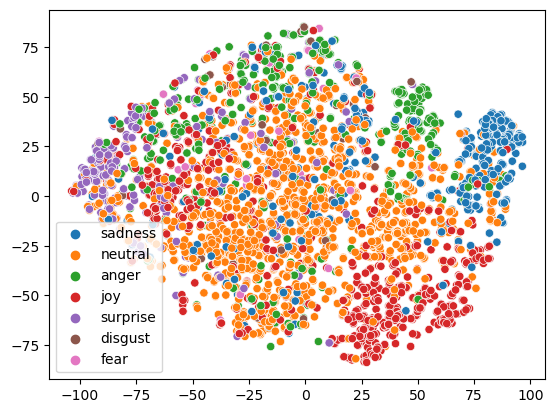

Epoch: 1 - Train Loss: 5.872646846602448


100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it]


Cosine Similarity between mods: 0.3174926551773281
Mean norm audio tensor(0.4057)
Mean norm text tensor(0.5943)
General - KNN F1: 0.635266817157892 Acc: 0.6411321734614386
Iemocap - KNN F1: 0.759004010124965 Acc: 0.7550362610797744
Iemocap - KNN F1 - Only Audio: 0.44475357342413746
Meld - KNN F1: 0.5729148435439001 Acc: 0.5869731800766284
Meld - KNN F1 - Only Audio: 0.25840415552629376
Iemocap - KNN F1 (macro): 0.6114082897916748
Meld - KNN F1 (macro): 0.3988552589096563


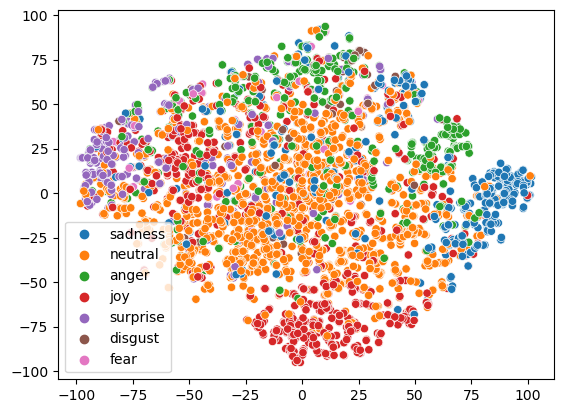

Epoch: 2 - Train Loss: 5.624576669878664


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Cosine Similarity between mods: 0.17890915911527647
Mean norm audio tensor(0.3338)
Mean norm text tensor(0.6662)
General - KNN F1: 0.627237237735832 Acc: 0.6325629706569722
Iemocap - KNN F1: 0.7471455788125291 Acc: 0.7389202256244963
Iemocap - KNN F1 - Only Audio: 0.4088670686431869
Meld - KNN F1: 0.5704466547695437 Acc: 0.581992337164751
Meld - KNN F1 - Only Audio: 0.24128679346506887
Iemocap - KNN F1 (macro): 0.5988729406321139
Meld - KNN F1 (macro): 0.388432187142757


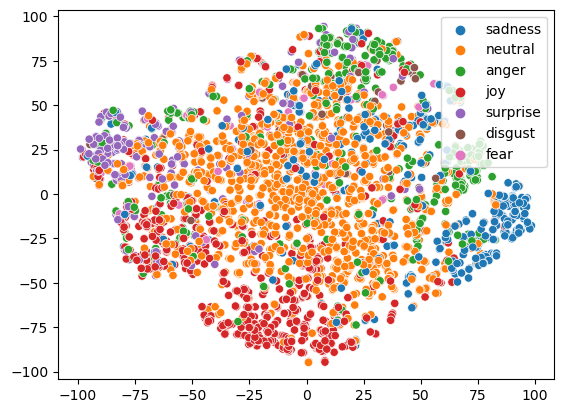

Epoch: 3 - Train Loss: 5.551034277519293


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


Cosine Similarity between mods: 0.21137943827496106
Mean norm audio tensor(0.3045)
Mean norm text tensor(0.6955)
General - KNN F1: 0.627307384010255 Acc: 0.6346403531550247
Iemocap - KNN F1: 0.740517907306996 Acc: 0.7348912167606769
Iemocap - KNN F1 - Only Audio: 0.4655409275335681
Meld - KNN F1: 0.5732633738973972 Acc: 0.5869731800766284
Meld - KNN F1 - Only Audio: 0.2955253906068238
Iemocap - KNN F1 (macro): 0.49717051119949557
Meld - KNN F1 (macro): 0.39193723431387545


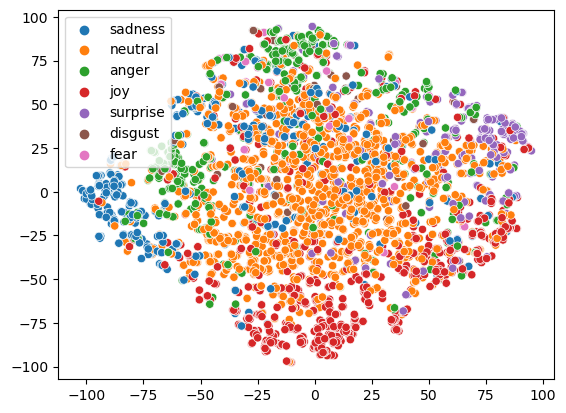

Epoch: 4 - Train Loss: 5.508386054925159


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.87s/it]


Cosine Similarity between mods: 0.22412977909552714
Mean norm audio tensor(0.2600)
Mean norm text tensor(0.7400)
General - KNN F1: 0.6265459829300121 Acc: 0.6341210075305116
Iemocap - KNN F1: 0.7424587802787331 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.4935658695941751
Meld - KNN F1: 0.5704010343661678 Acc: 0.5869731800766284
Meld - KNN F1 - Only Audio: 0.3139137378426053
Iemocap - KNN F1 (macro): 0.49646707980606725
Meld - KNN F1 (macro): 0.3957809992507372


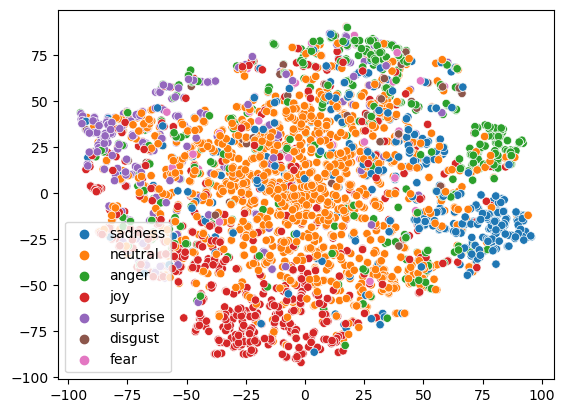

Epoch: 5 - Train Loss: 5.461427861610345


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


Cosine Similarity between mods: 0.23653667234996795
Mean norm audio tensor(0.2400)
Mean norm text tensor(0.7600)
General - KNN F1: 0.6316784894604174 Acc: 0.6390547909633861
Iemocap - KNN F1: 0.7611808803971584 Acc: 0.7534246575342466
Iemocap - KNN F1 - Only Audio: 0.47372568542687066
Meld - KNN F1: 0.5690282230535525 Acc: 0.5846743295019157
Meld - KNN F1 - Only Audio: 0.30552323074891874
Iemocap - KNN F1 (macro): 0.6104207206216246
Meld - KNN F1 (macro): 0.3958348845355245


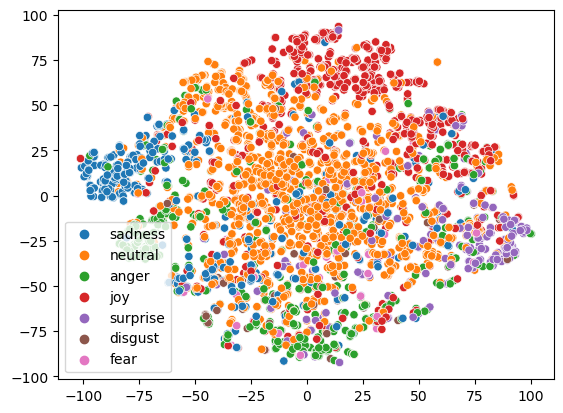

Epoch: 6 - Train Loss: 5.417829808935655


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.93s/it]


Cosine Similarity between mods: 0.3449421349948674
Mean norm audio tensor(0.2429)
Mean norm text tensor(0.7571)
General - KNN F1: 0.6199643396838825 Acc: 0.6271098415995845
Iemocap - KNN F1: 0.7492741703098066 Acc: 0.7421434327155519
Iemocap - KNN F1 - Only Audio: 0.4853809977531385
Meld - KNN F1: 0.5559197244216081 Acc: 0.5724137931034483
Meld - KNN F1 - Only Audio: 0.3218189105902642
Iemocap - KNN F1 (macro): 0.6022112031895743
Meld - KNN F1 (macro): 0.38344860106517026


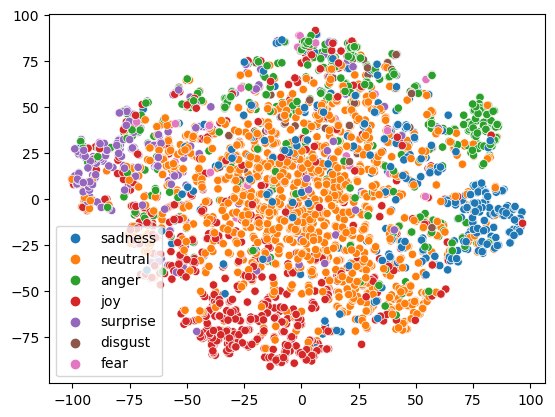

Epoch: 7 - Train Loss: 5.38435322837492


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


Cosine Similarity between mods: 0.35134653920045117
Mean norm audio tensor(0.2259)
Mean norm text tensor(0.7741)
General - KNN F1: 0.6349308571765334 Acc: 0.6437289015840042
Iemocap - KNN F1: 0.7554148335892069 Acc: 0.7485898468976632
Iemocap - KNN F1 - Only Audio: 0.5115829601155838
Meld - KNN F1: 0.5747426838860402 Acc: 0.5938697318007663
Meld - KNN F1 - Only Audio: 0.33867577935888704
Iemocap - KNN F1 (macro): 0.6060560596823757
Meld - KNN F1 (macro): 0.39535660122924404


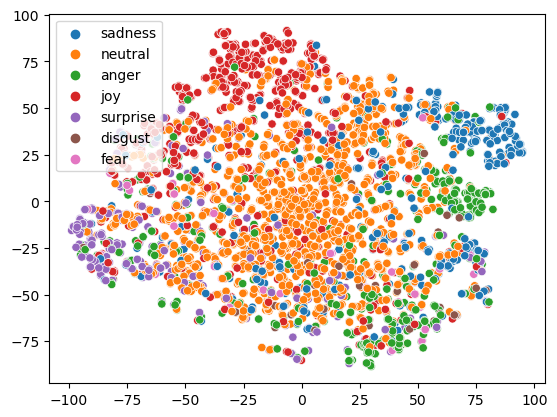

Epoch: 8 - Train Loss: 5.349110957795539


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


Cosine Similarity between mods: 0.3660006903264777
Mean norm audio tensor(0.2154)
Mean norm text tensor(0.7846)
General - KNN F1: 0.6273959032668037 Acc: 0.6351596987795378
Iemocap - KNN F1: 0.7323478773250347 Acc: 0.7228041901692184
Iemocap - KNN F1 - Only Audio: 0.49900168127668165
Meld - KNN F1: 0.5772897857375228 Acc: 0.5934865900383142
Meld - KNN F1 - Only Audio: 0.32654835428720724
Iemocap - KNN F1 (macro): 0.4884148971574287
Meld - KNN F1 (macro): 0.4030837164640611


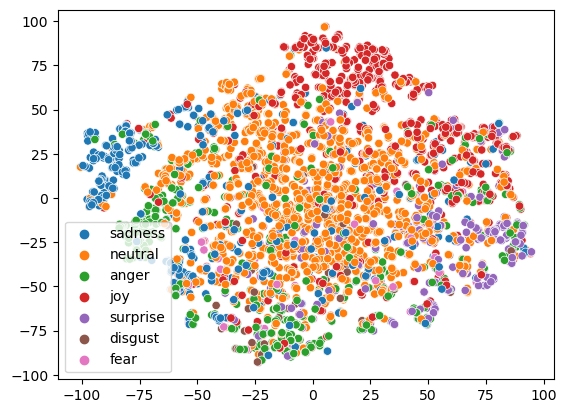

Epoch: 9 - Train Loss: 5.318269358272046


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.3870032188397697
Mean norm audio tensor(0.1975)
Mean norm text tensor(0.8025)
General - KNN F1: 0.6223435443293756 Acc: 0.6299662425344067
Iemocap - KNN F1: 0.7506265433082264 Acc: 0.7445608380338437
Iemocap - KNN F1 - Only Audio: 0.5147907189810761
Meld - KNN F1: 0.5606510521514806 Acc: 0.5754789272030651
Meld - KNN F1 - Only Audio: 0.3155636224690999
Iemocap - KNN F1 (macro): 0.6001425514334322
Meld - KNN F1 (macro): 0.38986475832629625


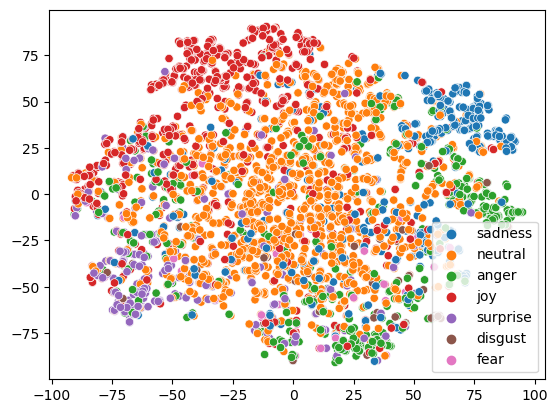

Epoch: 10 - Train Loss: 5.287324196469467


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.4336247351286598
Mean norm audio tensor(0.1911)
Mean norm text tensor(0.8089)
General - KNN F1: 0.638541491320335 Acc: 0.6478836665801091
Iemocap - KNN F1: 0.7590067903975105 Acc: 0.7510072522159549
Iemocap - KNN F1 - Only Audio: 0.5092790096647852
Meld - KNN F1: 0.5798331627450617 Acc: 0.5988505747126437
Meld - KNN F1 - Only Audio: 0.33395401193674745
Iemocap - KNN F1 (macro): 0.5063382680138931
Meld - KNN F1 (macro): 0.40170797165208816


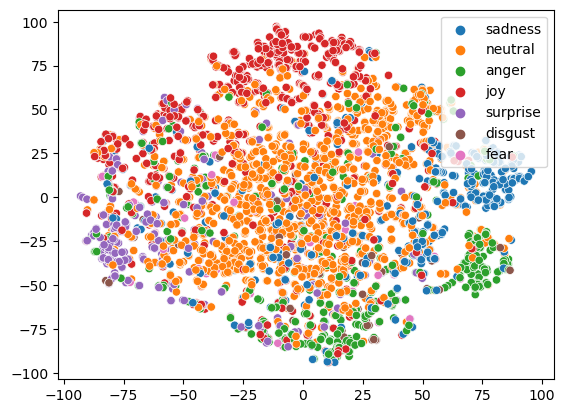

Epoch: 11 - Train Loss: 5.265738407067493


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.92s/it]


Cosine Similarity between mods: 0.4305052379607164
Mean norm audio tensor(0.1858)
Mean norm text tensor(0.8142)
General - KNN F1: 0.6235772015785714 Acc: 0.6333419890937418
Iemocap - KNN F1: 0.7369317566198009 Acc: 0.7292506043513296
Iemocap - KNN F1 - Only Audio: 0.49669664546158043
Meld - KNN F1: 0.5688134925140846 Acc: 0.5877394636015326
Meld - KNN F1 - Only Audio: 0.3307596274475356
Iemocap - KNN F1 (macro): 0.4924338410211427
Meld - KNN F1 (macro): 0.3925653783811848


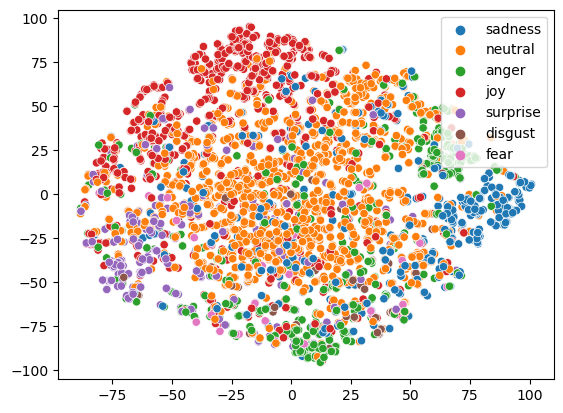

Epoch: 12 - Train Loss: 5.239608338448853


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.4628447495754958
Mean norm audio tensor(0.1849)
Mean norm text tensor(0.8151)
General - KNN F1: 0.6273539289117696 Acc: 0.636198390028564
Iemocap - KNN F1: 0.7484923787702175 Acc: 0.741337630942788
Iemocap - KNN F1 - Only Audio: 0.4903670005183676
Meld - KNN F1: 0.5680019810112874 Acc: 0.5862068965517241
Meld - KNN F1 - Only Audio: 0.33191261645126713
Iemocap - KNN F1 (macro): 0.5981087717913816
Meld - KNN F1 (macro): 0.3955938200211585


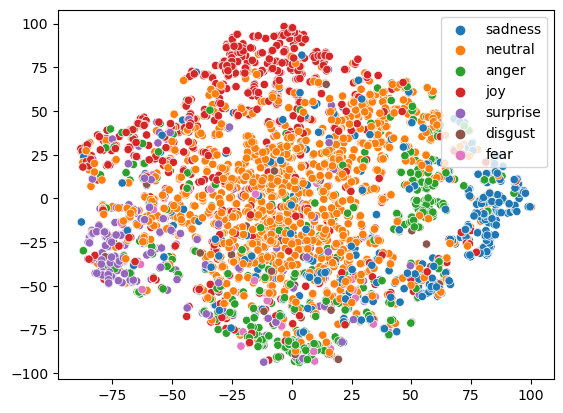

Epoch: 13 - Train Loss: 5.221222147477412


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


Cosine Similarity between mods: 0.481530311602303
Mean norm audio tensor(0.1810)
Mean norm text tensor(0.8190)
General - KNN F1: 0.6253364068129086 Acc: 0.6333419890937418
Iemocap - KNN F1: 0.7463862439260991 Acc: 0.7373086220789685
Iemocap - KNN F1 - Only Audio: 0.4759651193244209
Meld - KNN F1: 0.5669275089196595 Acc: 0.5839080459770115
Meld - KNN F1 - Only Audio: 0.34891360275593336
Iemocap - KNN F1 (macro): 0.49930489664229305
Meld - KNN F1 (macro): 0.3959304478332701


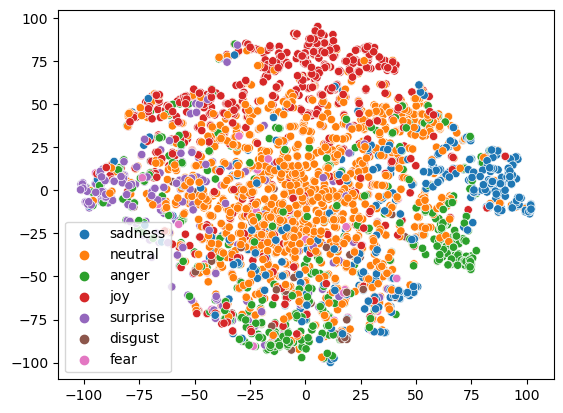

Epoch: 14 - Train Loss: 5.200383823529809


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.49256711141130144
Mean norm audio tensor(0.1883)
Mean norm text tensor(0.8117)
General - KNN F1: 0.6283615150506189 Acc: 0.6387951181511295
Iemocap - KNN F1: 0.7663699969588881 Acc: 0.7598710717163578
Iemocap - KNN F1 - Only Audio: 0.5140144327862716
Meld - KNN F1: 0.5603053811412225 Acc: 0.5812260536398467
Meld - KNN F1 - Only Audio: 0.34335107151929406
Iemocap - KNN F1 (macro): 0.6118189780604949
Meld - KNN F1 (macro): 0.37166182186598623


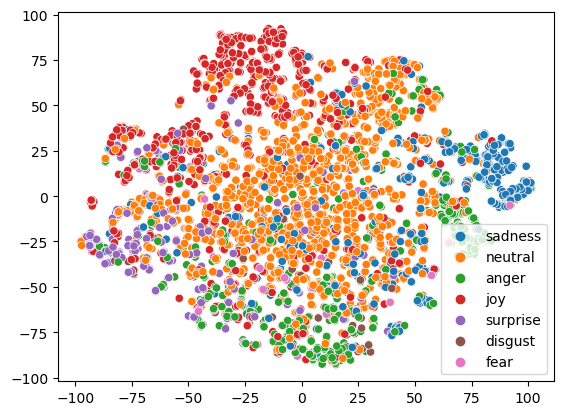

Epoch: 15 - Train Loss: 5.184313858504844


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.5201121379542245
Mean norm audio tensor(0.1781)
Mean norm text tensor(0.8219)
General - KNN F1: 0.6190404708824501 Acc: 0.6304855881589198
Iemocap - KNN F1: 0.7530632051897943 Acc: 0.7461724415793715
Iemocap - KNN F1 - Only Audio: 0.5146599791965784
Meld - KNN F1: 0.5508056581004654 Acc: 0.5754789272030651
Meld - KNN F1 - Only Audio: 0.36591753542239264
Iemocap - KNN F1 (macro): 0.6011291217201542
Meld - KNN F1 (macro): 0.36173603470016935


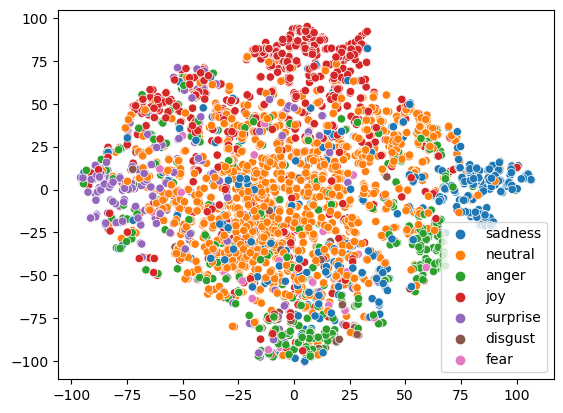

Epoch: 16 - Train Loss: 5.165012030474908


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.92s/it]


Cosine Similarity between mods: 0.5167055964562776
Mean norm audio tensor(0.1770)
Mean norm text tensor(0.8230)
General - KNN F1: 0.6215337792471906 Acc: 0.631524279407946
Iemocap - KNN F1: 0.7527211893028154 Acc: 0.7453666398066076
Iemocap - KNN F1 - Only Audio: 0.5006431400134393
Meld - KNN F1: 0.5558951640277446 Acc: 0.5773946360153257
Meld - KNN F1 - Only Audio: 0.34171721302372154
Iemocap - KNN F1 (macro): 0.6017466425859035
Meld - KNN F1 (macro): 0.3748429969082897


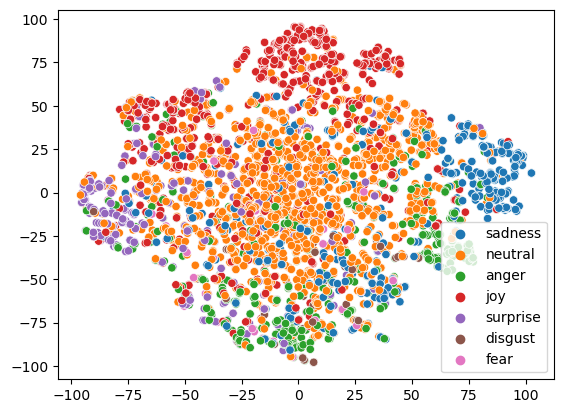

Epoch: 17 - Train Loss: 5.146695698257041


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.93s/it]


Cosine Similarity between mods: 0.5339682595632628
Mean norm audio tensor(0.1851)
Mean norm text tensor(0.8149)
General - KNN F1: 0.6195986050184968 Acc: 0.6325629706569722
Iemocap - KNN F1: 0.7596101705773557 Acc: 0.7518130539887188
Iemocap - KNN F1 - Only Audio: 0.5018859221620217
Meld - KNN F1: 0.549577017656139 Acc: 0.5758620689655173
Meld - KNN F1 - Only Audio: 0.34078206959759844
Iemocap - KNN F1 (macro): 0.6081319406407903
Meld - KNN F1 (macro): 0.3655998185915405


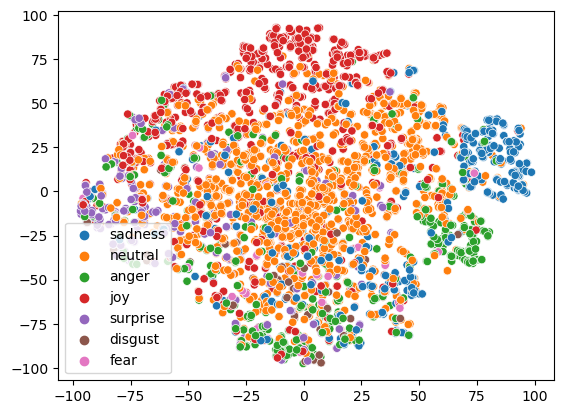

Epoch: 18 - Train Loss: 5.130484353124568


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


Cosine Similarity between mods: 0.5158211731099673
Mean norm audio tensor(0.1835)
Mean norm text tensor(0.8165)
General - KNN F1: 0.6138782786940149 Acc: 0.6252921319137886
Iemocap - KNN F1: 0.750855557107811 Acc: 0.7437550362610797
Iemocap - KNN F1 - Only Audio: 0.5035368840268865
Meld - KNN F1: 0.5464579275849677 Acc: 0.5689655172413793
Meld - KNN F1 - Only Audio: 0.3440831625968323
Iemocap - KNN F1 (macro): 0.602466286904584
Meld - KNN F1 (macro): 0.3640442648198663


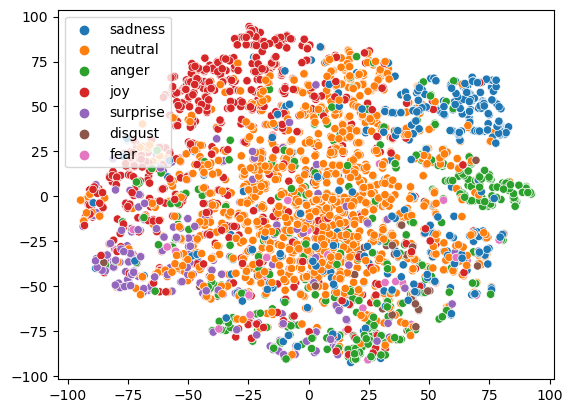

Epoch: 19 - Train Loss: 5.114688974566164


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


Cosine Similarity between mods: 0.5389202853915784
Mean norm audio tensor(0.1854)
Mean norm text tensor(0.8146)
General - KNN F1: 0.6161027503797643 Acc: 0.6297065697221501
Iemocap - KNN F1: 0.7425298982936698 Acc: 0.7356970185334408
Iemocap - KNN F1 - Only Audio: 0.5029423022958723
Meld - KNN F1: 0.5522317680488613 Acc: 0.5793103448275863
Meld - KNN F1 - Only Audio: 0.34181681270181274
Iemocap - KNN F1 (macro): 0.5973067456316388
Meld - KNN F1 (macro): 0.36929785260823417


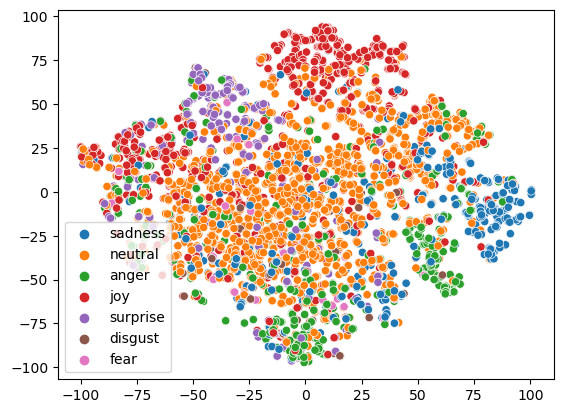

Epoch: 20 - Train Loss: 5.095959950337368


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


Cosine Similarity between mods: 0.5520317495658595
Mean norm audio tensor(0.1807)
Mean norm text tensor(0.8193)
General - KNN F1: 0.6093241239386683 Acc: 0.6216567125421968
Iemocap - KNN F1: 0.7433819617464688 Acc: 0.7348912167606769
Iemocap - KNN F1 - Only Audio: 0.5064894471029447
Meld - KNN F1: 0.5425605033199208 Acc: 0.5678160919540229
Meld - KNN F1 - Only Audio: 0.3499504274417836
Iemocap - KNN F1 (macro): 0.4953946362218706
Meld - KNN F1 (macro): 0.36025795760472606


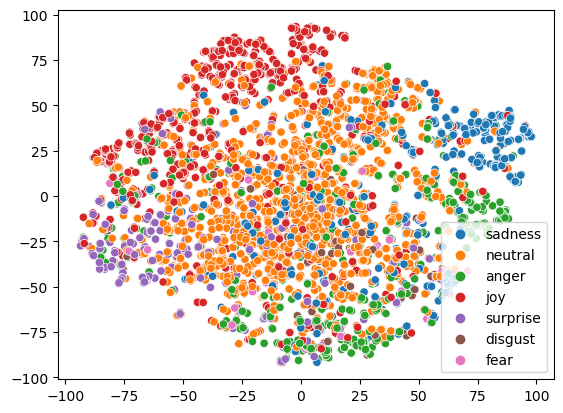

Epoch: 21 - Train Loss: 5.07848379675266


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]


Cosine Similarity between mods: 0.5246106318392342
Mean norm audio tensor(0.1852)
Mean norm text tensor(0.8148)
General - KNN F1: 0.6170246240441529 Acc: 0.6294468969098935
Iemocap - KNN F1: 0.7465188108984527 Acc: 0.7397260273972602
Iemocap - KNN F1 - Only Audio: 0.4893233387235349
Meld - KNN F1: 0.551391957622261 Acc: 0.5770114942528736
Meld - KNN F1 - Only Audio: 0.3518348554314358
Iemocap - KNN F1 (macro): 0.5991097661833228
Meld - KNN F1 (macro): 0.3694441542313252


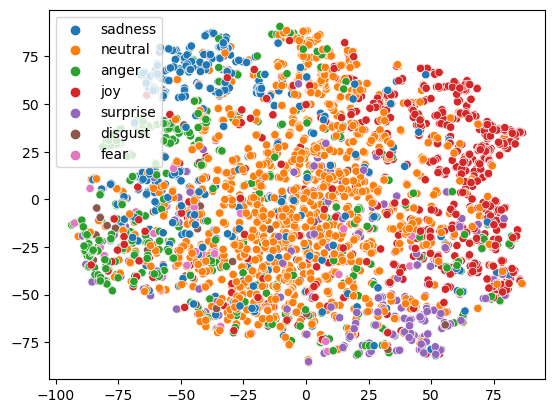

Epoch: 22 - Train Loss: 5.066413081852736


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


Cosine Similarity between mods: 0.5597473635855541
Mean norm audio tensor(0.1874)
Mean norm text tensor(0.8126)
General - KNN F1: 0.6103479558513023 Acc: 0.6247727862892755
Iemocap - KNN F1: 0.7536362584681703 Acc: 0.7445608380338437
Iemocap - KNN F1 - Only Audio: 0.5020129875524875
Meld - KNN F1: 0.5367605727106836 Acc: 0.5678160919540229
Meld - KNN F1 - Only Audio: 0.34394625742692153
Iemocap - KNN F1 (macro): 0.6043135428057579
Meld - KNN F1 (macro): 0.3515448490181891


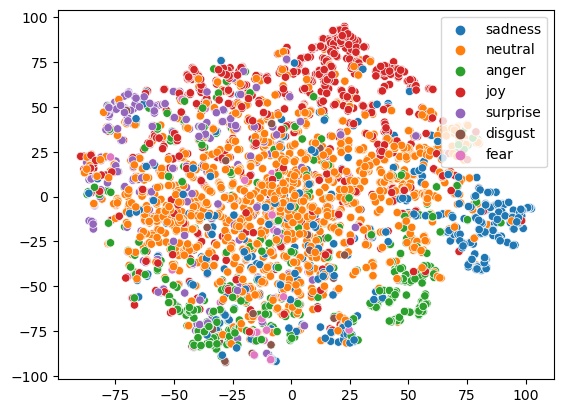

Epoch: 23 - Train Loss: 5.053874876646869


100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  2.00s/it]


Cosine Similarity between mods: 0.5395091137803086
Mean norm audio tensor(0.1785)
Mean norm text tensor(0.8215)
General - KNN F1: 0.6112785870517169 Acc: 0.6271098415995845
Iemocap - KNN F1: 0.7447082287655785 Acc: 0.7381144238517324
Iemocap - KNN F1 - Only Audio: 0.5111577601900084
Meld - KNN F1: 0.5430091416330716 Acc: 0.5743295019157089
Meld - KNN F1 - Only Audio: 0.3524875889633161
Iemocap - KNN F1 (macro): 0.5959570861026965
Meld - KNN F1 (macro): 0.34876357932518215


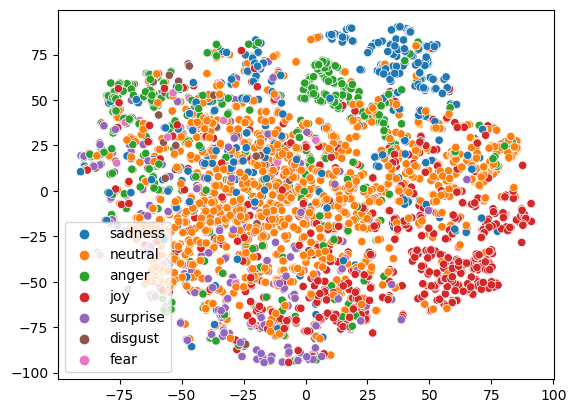

Epoch: 24 - Train Loss: 5.042223153916081


100%|█████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]


Cosine Similarity between mods: 0.540074287281814
Mean norm audio tensor(0.1868)
Mean norm text tensor(0.8132)
General - KNN F1: 0.6096403178604076 Acc: 0.6265904959750714
Iemocap - KNN F1: 0.7415343253686374 Acc: 0.7332796132151491
Iemocap - KNN F1 - Only Audio: 0.4910981974882021
Meld - KNN F1: 0.5443901727600655 Acc: 0.5758620689655173
Meld - KNN F1 - Only Audio: 0.34262697665702313
Iemocap - KNN F1 (macro): 0.5933191320678963
Meld - KNN F1 (macro): 0.3517918061722863


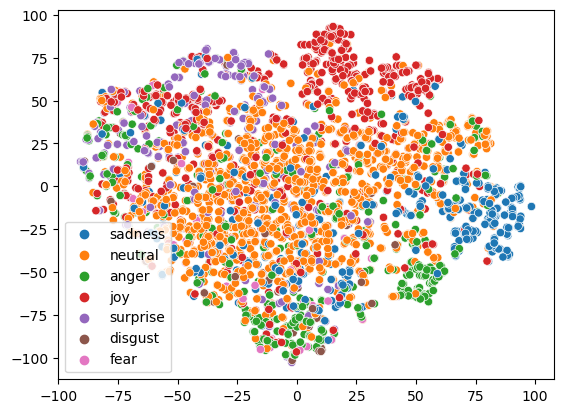

Epoch: 25 - Train Loss: 5.0240576457133335


 67%|████████████████████████████▏             | 76/113 [01:24<00:41,  1.11s/it]


KeyboardInterrupt: 

In [67]:
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_13'
!mkdir -p {PATH_TO_SAVE}
supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    rate=0.1,
)

# Grid search best temperatures
# Try to only fine tune on evaluation datasets
#supcon_model.load_state_dict(torch.load(f'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_4_layer/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

supcon_model.to(0)

scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

scheduler_epochs = 5
opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-4, betas=(0.9, 0.98), eps=1e-8)
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=0.5, end_factor=0.5, total_iters=5, last_epoch=- 1, verbose=False)
#scheduler = Scheduler(opt, 768, 600)

epochs = 9999

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []
    was = []
    wts = []
    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
        if i == len(train_loader)-1:
            continue
        batch = df_train.iloc[batch_indices[0]]
        only_text = batch[batch["path"].isna()]
        sentences = only_text["text"].tolist()
        y_text = torch.Tensor(lab_encoder.transform(only_text["label"]))
        y_text_senti = torch.Tensor(lab_encoder_senti.transform(only_text["sentiment_label"]))
        
        only_audio = batch[batch["text"].isna()]
        audio_paths = only_audio["path"].tolist()

        mfccs, att = audio_tokenizer.batch_tokenize(audio_paths)

        audio_input = {
            "features": mfccs.float().to(0),
            "attn_masks": att.float().to(0),
        }

        y_audio = torch.Tensor(lab_encoder.transform(only_audio["label"]))
        y_audio_senti = torch.Tensor(lab_encoder_senti.transform(only_audio["sentiment_label"]))
        
        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()].reset_index(drop=True)
        
        mult_not_na_idx = mult[mult["label"].notna()].index
        #batch_not_na_idx = batch[batch["label"].notna()].index
        #mult_na_idx = mult[mult["label"].isna()].index
        
        y_mult = torch.Tensor(lab_encoder.transform(mult.iloc[mult_not_na_idx]["label"]))
        
        y_mult_senti = torch.Tensor(lab_encoder_senti.transform(mult["sentiment_label"]))
        
        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]
        
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)
        
        # Augment Text Context
        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]
        
        for k, s in enumerate(sentences):
            if '[BFR]' in s:
                pass
            else:
                sentences[k] = '[BFR] ' + sentences[k]

            if '[AFT]' in s:
                pass
            else:
                sentences[k] = sentences[k] + ' [AFT]'
                
        for k, s in enumerate(sentences_mult):
            if '[BFR]' in s:
                pass
            else:
                sentences_mult[k] = '[BFR] ' + sentences_mult[k]

            if '[AFT]' in s:
                pass
            else:
                sentences_mult[k] = sentences_mult[k] + ' [AFT]'
                
        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}
        
        target = torch.cat([y_text, y_audio, y_mult]).long().cuda()
        target_senti = torch.cat([y_text_senti, y_audio_senti, y_mult_senti]).long().cuda()
        
        x = [sentences, audio_input, multimodal]
        
        if len(sentences) == 0:
            x[0] = None
        if len(audio_paths) == 0:
            x[1] = None
        if len(sentences_mult) == 0:
            x[2] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult_text_norm = F.normalize(x_mult_text, dim=-1)
                x_mult_audio_norm = F.normalize(x_mult_audio, dim=-1)
                
                #weights = torch.stack([torch.norm(x_mult_audio, dim=-1), torch.norm(x_mult_text, dim=-1)], dim=0).detach()
                wa = torch.norm(x_mult_audio, dim=-1).detach()
                wt = torch.norm(x_mult_text, dim=-1).detach()
                weights = torch.cat([wa, wt], dim=0).detach()
                was.append(wa.cpu())
                wts.append(wt.cpu())

                # Augument modality
                augs = random.choices(
                    population=[0, 1, 2],
                    weights=[0.6, 0.2, 0.2],
                    k=len(x_mult_text)
                )
                
                x_mult = torch.stack([F.normalize(x_mult_text + x_mult_audio, dim=-1), 
                                      x_mult_text_norm, 
                                     x_mult_audio_norm], dim=1)
                
                x_mult = x_mult[list(range(len(augs))), augs, :] 
                
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                # Add weighted contrastive loss
                #x_mult_text = x_mult_text_norm.unsqueeze(dim=1)
                #x_mult_audio = x_mult_audio_norm.unsqueeze(dim=1)
                #mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                out_x, out_x_wide = None, None
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0) #.unsqueeze(dim=1)
                        out_x_lab = torch.cat([out["x_text"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                elif x[1] is not None:
                    out_x = torch.cat([out["x_audio"], x_mult], dim=0) #.unsqueeze(dim=1)
                    out_x_lab = torch.cat([out["x_audio"], x_mult[mult_not_na_idx]], dim=0) #.unsqueeze(dim=1)
                    out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide[mult_not_na_idx]], dim=0)
                else:
                    out_x = x_mult.unsqueeze(dim=1)
                    out_x_lab = x_mult[mult_not_na_idx] #.unsqueeze(dim=1)
                    out_x_wide = x_mult_wide[mult_not_na_idx]
                
                # fera ta
                
                loss = 0.5 * (0.8 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.2 * sup_contrastive_loss(out_x, target_senti, temperature=0.1)) \
                        + 0.5 * 2 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.2, weights=weights)
                #loss = 0.5 * (0.5 * supcon_loss(out_x_lab, labels=target) + 0.5 * supcon_loss_senti(out_x, labels=target_senti)) + 0.5 * supcon_loss_intra(mult, weights=weights) 
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = 0.9 * sup_contrastive_loss(out_x_lab, target, temperature=0.1) + 0.1 * sup_contrastive_loss(out_x, target_senti, temperature=0.1) #+ 0.8 * unsupervised_contrastive_loss(x_mult_text_norm, x_mult_audio_norm, temperature=0.8, weights=None)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        #torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        #scheduler.step()
        
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del x_mult
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
    scheduler.step()
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    #supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    wide_audio = []
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_batch = test_df_erc.iloc[batch_indices[0]]

            audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
            mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

            sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

            for k, s in enumerate(sentences_mult):
                if '[BFR]' in s:
                    pass
                else:
                    sentences_mult[k] = '[BFR] ' + sentences_mult[k]

                if '[AFT]' in s:
                    pass
                else:
                    sentences_mult[k] = sentences_mult[k] + ' [AFT]'
                
            multimodal = {'sentences': sentences_mult, 
                          'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

            target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(F.normalize(out["x_mult_text_wide"], dim=-1), F.normalize(out["x_mult_audio_wide"], dim=-1))

            wide = np.array(out_x_wide.cpu())
            wide_audio.append(np.array(F.normalize(out["x_mult_audio_wide"], dim=-1).cpu()))
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    wide_audio = np.concatenate(wide_audio, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(test_df_erc)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    print(f'Cosine Similarity between mods: {css}')
    
    meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
    iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index
    
    general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
    general_f1_iemocap_audio = f1_score(targets_val[iemocap_idx], clf.predict(wide_audio)[iemocap_idx], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])
    
    general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
    general_f1_meld_audio = f1_score(targets_val[meld_idx], clf.predict(wide_audio)[meld_idx], average='weighted')
    general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])
    
    print("Mean norm audio", torch.cat(was).mean())
    print("Mean norm text", torch.cat(wts).mean())
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
    print(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
    print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
    print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

    try:
        tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

        sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
        plt.show()
    
    except:
        pass
    
    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1
    
    #if e == scheduler_epochs: # Unfreeze text encoder
    #    for i, (name, param) in enumerate(list(supcon_model.text_encoder.named_parameters())):
    #        param.requires_grad = True

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1: {general_f1} Acc: {general_acc}')
        f.write(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
        f.write(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f'Iemocap - KNN F1 - Only Audio: {general_f1_iemocap_audio}')
        f.write(f'Meld - KNN F1 - Only Audio: {general_f1_meld_audio}')
        f.write(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
        
        f.write(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
torch.cat(wts).mean()

In [ ]:
np.array(torch.Tensor(was).mean())

In [ ]:
list(weights.cpu().numpy())[8]

In [ ]:
sentences_mult[:8]

In [ ]:
len(multimodal["sentences"])

In [ ]:
sentences

In [ ]:
mult.head(20)["text"].tolist()

In [ ]:
"""
Cosine Similarity between mods: 0.6148036817116292
General - KNN F1: 0.652949920693673 Acc: 0.6535964684497533
Iemocap - KNN F1: 0.7621117618450867 Acc: 0.7558420628525383
Iemocap - KNN F1 - Only Audio: 0.48286032752145575
Meld - KNN F1: 0.6025222678926638 Acc: 0.6049808429118774
Iemocap - KNN F1 (macro): 0.6085758686292261
Meld - KNN F1 (macro): 0.41899567212117655

Epoch: 31 - Train Loss: 6.175596459077136
"""

## Eval

In [ ]:
ss

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [ ]:
gc.collect()

In [ ]:
#PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_5_layer_pivoting_to_speech_training'

In [ ]:
#torch.load(f'pre_test_final_2/pytorch_model_AudioTextCLIP_epoch_35.bin')['model']
#torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_1.bin')['model']

In [ ]:
PATH_TO_SAVE = 'ESTAMOS_PERTO_AMIGO_ESTOU_AQUI_4_freezed_11'

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    rate=0.0,
).cuda()
supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_15.bin')['model'])

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(supcon_model)

In [ ]:
supcon_model.eval()

In [ ]:
import pickle

In [ ]:
supcon_model.train()
test = supcon_model([["I Hate you, i believe you are shit!", "You are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
test = supcon_model([["I love you, mate!", "Fuck you, you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][1, :], dim=-1))

In [ ]:
supcon_model.train()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.100.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am very sad"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
torch.norm(test["x_text"][0, :])

In [ ]:
torch.norm(test["x_audio"][0, :])

In [ ]:
supcon_model.eval()
supcon_model.training = False
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.101.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I love my girlfriend, but she died"],audio_input, None])
    print(torch.dot(test["x_text"][0, :], test["x_audio"][0, :]))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I am sad"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.sad.279.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["My dog was great, but he was also cute! Today he is dead"], audio_input, None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=-1), F.normalize(test["x_audio"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I had a discussion with my mother", "I love my mother"],audio_input, None])
    print(torch.dot(test["x_text_wide"][0, :], test["x_audio_wide"][0, :]))
    print(torch.dot(test["x_text_wide"][1, :], test["x_audio_wide"][0, :]))

In [ ]:
with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.50.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I just finished my PhD!!", "I finished my PhD, but I dont have a job"],audio_input, None])
    print(torch.dot(F.normalize(test["x_text_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_text_wide"][1, :], dim=-1), F.normalize(test["x_audio_wide"][0, :], dim=-1)))

In [ ]:
supcon_model.train()
supcon_model.training = False
dropout_modules = [module for module in supcon_model.modules() if isinstance(module,torch.nn.Dropout)]
[module.eval() for module in dropout_modules]

with torch.no_grad():
    m, a = audio_tokenizer.batch_tokenize(["./audio/audio_emo/tess.woman.happy.279.wav", "./audio/audio_emo/tess.woman.sad.59.wav"])
    audio_input = {
        "features": m.float().to(0),
        "attn_masks": a.float().to(0),
    }
    test = supcon_model([["I did not pass in the final exam, i will kill myself"], audio_input, None])
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_audio_wide"][1, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][0, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))
    print(torch.dot(F.normalize(test["x_audio_wide"][1, :], dim=-1), F.normalize(test["x_text_wide"][0, :], dim=-1)))

In [ ]:
test

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        activation[name] = output #.detach()
    return hook

In [ ]:
get_activation

In [ ]:
supcon_model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(output)
        print(output.shape)
        activation[name] = output #.detach()
    return hook

supcon_model = AudioTextContrastive(
    text_encoder,
    audio_encoder,
    in_features_text=768,
    in_features_audio=dim_embed, 
    hidden_size=768,
    wide_proj=1024,
    proj_size=128, 
    freeze_text_enc=True,
    freeze_audio_enc=False,
    rate=0.2,
).cuda()

supcon_model.load_state_dict(torch.load(f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_16.bin')['model'])

supcon_model.audio_proj.register_forward_hook(get_activation('audio_proj'))
output = supcon_model([["I had a discussion with my mother"],audio_input, None])
activation['audio_proj']

In [ ]:
m

In [ ]:
test["x_audio_wide"][0, :]

In [ ]:
test["x_audio"][0, :]

In [ ]:
test

In [ ]:
print(df_train[df_train["label"] == "sadness"]["path"].tolist())

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_f =df_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
meld_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: True if "MELD" in x else False)].index

In [ ]:
iemocap_train_idx = train_df_erc[train_df_erc["path"].apply(lambda x: False if "MELD" in x else True)].index

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[iemocap_train_idx].reset_index(drop=True)
#train_iemocap = train_df_erc.iloc[meld_train_idx].reset_index(drop=True)
train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_df_erc)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(test_df_erc)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
batch

In [ ]:
supcon_model.train()

proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):
    with torch.no_grad():
        batch = train_df_erc.iloc[batch_indices[0]]

        mult = batch[batch["text"].notna()]
        mult = mult[mult["path"].notna()]
        mult = mult[mult["label"].notna()]
        y_mult = torch.Tensor(lab_encoder.transform(mult["label"]))

        audio_path_mult = [str(t['path']) for _, t in mult.iterrows()]

        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in mult.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = y_mult

        x = [None, None, multimodal]

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #x_mult_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        proj_train.append(np.array(x_mult_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del x_mult_wide
        gc.collect()
        torch.cuda.empty_cache()
proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)

clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))

preds = []
targets = []
css = 0.0

for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_batch = test_df_erc.iloc[batch_indices[0]]

        audio_path_mult = [str(t['path']) for _, t in multimodal_batch.iterrows()]
        mfccs_mult, att_mult = audio_tokenizer.batch_tokenize(audio_path_mult)

        sentences_mult = [str(t['text']) for _, t in multimodal_batch.iterrows()]

        multimodal = {'sentences': sentences_mult, 
                      'audio_input': {"features": mfccs_mult.float().to(0), "attn_masks": att_mult.float().to(0)}}

        target = torch.Tensor(lab_encoder.transform(list(multimodal_batch["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            #out_x_wide = F.normalize(out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)

preds = np.array(np.concatenate(preds, axis=0))

css = css / len(test_df_erc)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')

meld_idx = test_df_erc[test_df_erc["source"] == "meld"].index
iemocap_idx = test_df_erc[test_df_erc["source"] != "meld"].index

general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

print(f"Iemocap - KNN F1 (macro): {f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='macro')}")
print(f"Meld - KNN F1 (macro): {f1_score(targets_val[meld_idx], preds[meld_idx], average='macro')}")

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=lab_encoder.inverse_transform(list(np.array(targets_val, dtype=int))) , palette='tab10')
plt.show()

In [ ]:
train_iemocap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train[meld_train_idx].mean(axis=0)
std_test = proj_train[meld_train_idx].std(axis=0)
clf = FaissKNeighbors(k=128)
clf.fit((proj_train[meld_train_idx]-mean_test)/std_test, np.array(targets_train[meld_train_idx], dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

general_f1_meld = f1_score(targets_val[meld_idx], preds[meld_idx], average='weighted')
general_acc_meld = accuracy_score(targets_val[meld_idx], preds[meld_idx])

from sklearn.metrics import classification_report

print(classification_report(targets_val[meld_idx], preds[meld_idx], digits=4))

In [ ]:
len(targets_val[iemocap_idx])

In [ ]:
set(lab_encoder.inverse_transform(np.array(targets_val[iemocap_idx], dtype=int)))


In [ ]:
df_iemocap_orig = pd.read_json("emotions.json").reset_index(drop=False)
df_iemocap_orig = pd.melt(df_iemocap_orig, id_vars=['index'], value_vars=['train', 'val', 'test']).dropna().drop(columns=["variable"]).rename(columns={"index":"id", "value": "orig_label"}).reset_index(drop=True)
df_iemocap_orig = df_iemocap_orig[df_iemocap_orig["orig_label"].notna() & (df_iemocap_orig["orig_label"] != "undecided")].reset_index(drop=True)
df_iemocap_orig

In [ ]:
def cleaning_shit(x):
    if "MELD" in x:
        return None
    x = x.replace("val/", "")
    x = x.replace("train/", "")
    x = x.replace("test/", "")
    l = len("/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/")
    return x[l:].replace(".wav", "")


In [ ]:
#train_df_erc_iemocap = train_df_erc[train_df_erc["path"].apply(lambda x: True if "IEMOCAP" in x else False)]
train_df_erc["id"] = train_df_erc["path"].apply(cleaning_shit)
train_df_erc_iemocap = train_df_erc.dropna()
train_df_erc_iemocap = train_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner").dropna()
train_df_erc_iemocap

In [ ]:
len(iemocap_train_idx)

In [ ]:
test_df_erc["id"] = test_df_erc["path"].apply(lambda x: x[len('/home/vmachado/Documents/multimodal-datasets/IEMOCAP/raw-audios/test/'):].replace(".wav", "")) 

In [ ]:
test_df_erc_iemocap = test_df_erc[test_df_erc["source"] == "iemocap"].reset_index(drop=True)
test_df_erc_iemocap

In [ ]:
test_df_erc_iemocap = test_df_erc_iemocap.merge(df_iemocap_orig, on="id", how="inner")
test_df_erc_iemocap

In [ ]:
new_lab = LabelEncoder().fit(train_df_erc_iemocap["orig_label"])

In [ ]:
train_df_erc_iemocap["orig_label"].unique()

In [ ]:
test_df_erc_iemocap["orig_label"].unique()

In [ ]:
train_df_erc_iemocap

In [ ]:
test_df_erc_iemocap

In [ ]:
correct_labels_train = new_lab.transform(train_df_erc_iemocap["orig_label"])
correct_labels_test = new_lab.transform(test_df_erc_iemocap["orig_label"])

In [ ]:
correct_labels_train

In [ ]:
lab_encoder.classes_

In [ ]:
test_df_erc[test_df_erc["source"] == "iemocap"]["label"].value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)

#clf = MLPClassifier(hidden_layer_sizes=(768,), learning_rate="invscaling", solver="sgd", max_iter=5000, validation_fraction=0.2, nesterovs_momentum=False)
clf = LogisticRegression()
clf.fit((proj_train-mean_test)/std_test, np.array(targets_train, dtype=int))

preds = clf.predict((proj_val-mean_test)/std_test)

from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], preds[iemocap_idx], digits=4))

In [ ]:
general_f1_iemocap = f1_score(targets_val[iemocap_idx], preds[iemocap_idx], average='weighted')
general_acc_iemocap = accuracy_score(targets_val[iemocap_idx], preds[iemocap_idx])



In [ ]:
general_f1_iemocap

In [ ]:
general_f1_meld

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val[iemocap_idx], list(map(lambda x: x if x != 1 else 6, preds[iemocap_idx])), digits=4))

## 